# Product Classification (NLP) : World Bank Project

In [33]:
__author__ = "Andy Chiv"
__email__  = "andychiv7@gmail.com"

# 1. Introduction

In this project, we will be looking at a dataset containing approximately 2000 product descriptions in the USA and UAE.  **Provided by Cal Poly DxHub**, this datasets include 4 main stores: Target (USA), Walmart (USA), Noon (UAE), Ubuy (UAE). The objective in this project is to answer: 

- How can products be categorized using **classification models**?

After performing data preprocessing, this dataset contains the following relevant features: 

* 'uuid' = Unique Product ID
* 'Store' = Store at which the products are sold
* 'Category' = Category of the products
* 'Description' = Product description
* 'Price' = Price of the product in a retail store (in dollars)
* 'Unit' = Unit of the product (gram, ounce, liters)
* 'Unit Price': Standardized Unit price (dollar/kilogram)

---------------------------------------------------------------------------

First, load libraries and data that we are going use in this project.

In [34]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import json
import re

from sklearn.model_selection import train_test_split

Loading the data called world_bank_products.csv found in this repository.

In [35]:
df = pd.read_csv('world_bank_products.csv')

# 2. Data Cleaning

This dataset is unorganized, and we will only choose Walmart, Target, Noon dataset to be cleaned since Ubuy sample size is too small (5). For each store, we will use **JSON**, **Pandas**, and **Numpy** to create a new clean data frame that captures only relevant information.

## 2.1 Walmart Data (USA)

In [36]:
# Call out only walmart data
walmart = df[df['store']=='walmart'].reset_index(drop=True)

# Extract the JSON data in walmart
wprod = pd.json_normalize(walmart['product-details'].apply(json.loads)).reset_index(drop=True)
# We need only product name, price, price per unit
wprod = wprod[['info.M.name.S', 'pricing.M.displayPrice.N', 'pricing.M.displayUnitPrice.S']]

# Concatenate walmart and wprod 
walmart = pd.concat([walmart[['uuid', 'store', 'product']], wprod], axis=1)
walmart.head(3)

,uuid,store,product,info.M.name.S,pricing.M.displayPrice.N,pricing.M.displayUnitPrice.S
0,f87fc9e2-a1c2-4728-97fb-a798aa96f4df,walmart,rice cooker,"Ben's Original™ Ready Rice™, Jasmine, 8.5 oz. ...",1.98,(23.3 ¢/oz)
1,1a039bfe-8fd9-420e-92b8-62c17b120b21,walmart,cereal,Malt-O-Meal Honey Nut Scooters® Breakfast Cere...,5.38,(13.8 ¢/oz)
2,2edebb8c-9706-468a-8d05-fbc521a690ba,walmart,milk,"Producers Whole Unflavored Milk, 1 Quart",1.34,(4.2 ¢/fl oz)


In [37]:
# Rename the colums 
name_map ={'pricing.M.displayPrice.N':'price',
             'info.M.name.S':'description',
             'pricing.M.displayUnitPrice.S':'displayedUnitPrice'}

walmart = walmart.rename(columns=name_map)
walmart.head(3)

,uuid,store,product,description,price,displayedUnitPrice
0,f87fc9e2-a1c2-4728-97fb-a798aa96f4df,walmart,rice cooker,"Ben's Original™ Ready Rice™, Jasmine, 8.5 oz. ...",1.98,(23.3 ¢/oz)
1,1a039bfe-8fd9-420e-92b8-62c17b120b21,walmart,cereal,Malt-O-Meal Honey Nut Scooters® Breakfast Cere...,5.38,(13.8 ¢/oz)
2,2edebb8c-9706-468a-8d05-fbc521a690ba,walmart,milk,"Producers Whole Unflavored Milk, 1 Quart",1.34,(4.2 ¢/fl oz)


In [38]:
# Regular Expression to extract unit prices
def extractPrice(r):
    if pd.isnull(r['displayedUnitPrice']):
        return np.nan
    price = float(re.search('[+-]?([0-9]*[.]?[0-9]+)', str(r['displayedUnitPrice'])).group(1))
    if '¢' in r['displayedUnitPrice']:
        return round(price/100, 2)
    return round(price, 3)

# RegEx to extract units
def extractUnit(r):
    if pd.isnull(r['displayedUnitPrice']):
        return np.nan
    return re.search('/(.*)\)$', str(r['displayedUnitPrice'])).group(1)


walmart['unitPrice'] = walmart.apply(extractPrice, axis=1)
walmart['unit'] = walmart.apply(extractUnit, axis=1)
walmart = walmart.drop('displayedUnitPrice', axis=1)

In [39]:
# Data imputation
walmart['unitPrice'] = walmart['unitPrice'].fillna(walmart['price'])
walmart['unit'] = walmart['unit'].fillna('ea')

# Clean units
def cleanUnit(r):
    unit = r['unit'].lower().replace('.', '')
    if unit == 'fluid ounce':
        return 'fl oz'
    return unit

walmart['unit'] = walmart.apply(cleanUnit, axis=1)
walmart = walmart.reindex(columns =["uuid", "store", "product", "description", "price", "unit", "unitPrice"])

# Final walmart data
walmart.head(3)

,uuid,store,product,description,price,unit,unitPrice
0,f87fc9e2-a1c2-4728-97fb-a798aa96f4df,walmart,rice cooker,"Ben's Original™ Ready Rice™, Jasmine, 8.5 oz. ...",1.98,oz,0.23
1,1a039bfe-8fd9-420e-92b8-62c17b120b21,walmart,cereal,Malt-O-Meal Honey Nut Scooters® Breakfast Cere...,5.38,oz,0.14
2,2edebb8c-9706-468a-8d05-fbc521a690ba,walmart,milk,"Producers Whole Unflavored Milk, 1 Quart",1.34,fl oz,0.04


## 2.2 Target Data (USA)

In [40]:
target = df[df['store']=='target'].reset_index(drop=True)
target.head(2)

,uuid,category,date-collected,product,product-details,query,store
0,d0349131-9f38-4774-952a-a6e54c0e9554,vegetables,2021-08-24,vegetables,"{""tcin"":{""S"":""47095644""},""pricing"":{""M"":{""curr...",vegetables,target
1,71cd340b-27f1-477b-a9c0-5f021bbf3b16,oils_fats,2021-08-24,butter,"{""tcin"":{""S"":""53930343""},""pricing"":{""M"":{""curr...",butter,target


In [41]:
tprod = pd.json_normalize(target['product-details'].apply(json.loads)).reset_index(drop=True)

# We need Product Description, 
tprod = tprod[['info.M.product_description.M.title.S',
              'info.M.product_description.M.bullet_descriptions.L',
              'pricing.M.current_retail.N']]

# Rename columns
nmap = {'info.M.product_description.M.title.S': 'description',
        'info.M.product_description.M.bullet_descriptions.L': 'information',
        'pricing.M.current_retail.N': 'price'}
tprod = tprod.rename(columns = nmap)

# Convert Price to Float Value
tprod['price'] = np.asarray(tprod["price"], dtype=float)
tprod.head(2)

,description,information,price
0,Avocado - each,[{'S': '<B>Contains:</B> Does Not Contain Any ...,0.69
1,Miyoko&#39;s European Style Cultured Vegan But...,"[{'S': '<B>Contains:</B> Coconut, Cashews'}, {...",6.29


In [42]:
# Description2 contains Net Weight                =======> Need to extract that value out
# Description1 contains Other product information =======> Need to extract that later (optional)

In [43]:
# Locating the net weight index
def find_net_weight(lst: list):
  ind = 0
  for dic in lst:
    if "Net weight" in list(dic.values())[0]:
      return ind
    ind += 1
  return None

# Extracting the net weight information
information = tprod['information']
net_weight = []
for i in range(0,len(information)): 
  index = find_net_weight(information[i])
  #print('--index', index)
  if index != None: 
    #print("digit", index)
    net_wei = information[i][index]["S"]
    net_weight.append(net_wei)
  else: 
    net_weight.append('None')
    
# net_weight

In [44]:
# Extracting the unit and amount from net_weight
amount = []
unit = []
pattern_num = '([0-9]*[.]?[0-9]+)'

for each_weight in net_weight: 
  result = re.findall(pattern_num, each_weight)
  if result == []: 
    amount.append(None)
  else: 
    amount.append(float(result[0])) 
    
for each_weight in net_weight:
  unit1 = "Ounces"
  unit1a = "oz"
  unit2 = "Pounds"
  unit2a = 'lb'
  unit3 = 'fl oz'
  unit3a = 'fl oz'
  if unit1 in each_weight:
    unit.append(unit1a)
  elif unit2 in each_weight: 
    unit.append(unit2a)
  elif unit3 in each_weight: 
    unit.append(unit3a)
  else: 
    unit.append(None) 

# Create a new dataframe from unit and amount   
nw = pd.DataFrame({'unit': unit, 'amount': amount}).reset_index(drop=True)
nw.head(3)

,unit,amount
0,oz,7.5
1,oz,8.0
2,oz,14.0


In [45]:
temp = pd.concat([tprod, nw], axis =1)
target = pd.concat([target[["uuid", "store", "product"]], temp], axis=1)
target.head(2)

# Calculate unitPrice =
target['unitPrice'] = round(target['price']/target['amount'], 3)

# Drop 'information' and 'amount'
target.drop(['information', 'amount'], axis=1, inplace = True)
# Final target data
target.head(3)

,uuid,store,product,description,price,unit,unitPrice
0,d0349131-9f38-4774-952a-a6e54c0e9554,target,vegetables,Avocado - each,0.69,oz,0.092
1,71cd340b-27f1-477b-a9c0-5f021bbf3b16,target,butter,Miyoko&#39;s European Style Cultured Vegan But...,6.29,oz,0.786
2,52c58065-fb85-4d7d-b700-a134a4547463,target,bread,Take And Bake Ciabatta Bread - 14oz - Favorite...,2.99,oz,0.214


## 2.3 Noon Data (UAE)

In [46]:
noon = df[df['store']=='noon'].reset_index(drop=True)
noon.head(2)

,uuid,category,date-collected,product,product-details,query,store
0,93fc6bce-7760-4ee0-b29c-29df2bcb1b50,vegetables,2021-08-24,vegetables,"{""images"":{""M"":{""image_keys"":{""L"":[{""S"":""v1628...",vegetables,noon
1,91c95b6f-9644-42b0-a54e-ec6e30eb03ca,fish_seafood,2021-08-23,seafood,"{""images"":{""M"":{""image_keys"":{""L"":[{""S"":""v1558...",seafood,noon


In [47]:
nprod = pd.json_normalize(noon['product-details'].apply(json.loads))
nprod = nprod[['name.S', 'pricing.M.price.N']]
nprod.head(3)

# Rename columns 
nmap = {'name.S':'description', 'pricing.M.price.N':'price(AED)'}
nprod = nprod.rename(columns=nmap)
nprod.head(3)

,description,price(AED)
0,Char Grilled Peppers 290g,13.6
1,Regular Fish Scaler Silver 6x3.5x11.5inch,157.95
2,Amla Heat Protect Snake Oil 50ml,32


In [48]:
# Convert price to USD 
# July 23 2022, Exchange Rate: 1USD = 3.67 AED
nprod['price'] = nprod['price(AED)'].apply(lambda x: round(float(x)/3.67,2))
nprod = nprod.drop('price(AED)', axis =1 )
nprod.head(3)

,description,price
0,Char Grilled Peppers 290g,3.71
1,Regular Fish Scaler Silver 6x3.5x11.5inch,43.04
2,Amla Heat Protect Snake Oil 50ml,8.72


In [49]:
noon = pd.concat([noon[['uuid', 'store', 'product']], nprod], axis=1)
noon.head(3)

,uuid,store,product,description,price
0,93fc6bce-7760-4ee0-b29c-29df2bcb1b50,noon,vegetables,Char Grilled Peppers 290g,3.71
1,91c95b6f-9644-42b0-a54e-ec6e30eb03ca,noon,seafood,Regular Fish Scaler Silver 6x3.5x11.5inch,43.04
2,3119a0f2-64a0-4ec7-ad01-f58fb89bcb0a,noon,oil,Amla Heat Protect Snake Oil 50ml,8.72


In [50]:
def extractUnit2(row):
  matches = re.search("([0-9]*[.]?[0-9]+)([a-zA-z]*)", str(row['description']))
  if matches:
    if matches.group(1) and matches.group(2):
      return pd.Series([float(matches.group(1)), matches.group(2).lower()])
  return pd.Series([None, None])

noon[['amount', 'unit']] = noon.apply(extractUnit2, axis=1)
noon['amount'] = noon['amount'].fillna(1)
noon['unit'] = noon['unit'].fillna('ea')

# 'x', 'n', 'a', 'fx', 'bbq', 'ss', 'st', 'd', 'e', 'usb', 'ebs', 'h', 'in', 'mm', 'fx', 'bk' -> 'ea'
# Convert to 'ea'
def cleanUnit2(row):
  unit_map = {'gm': 'g', 'grams': 'g', 'mililitre': 'ml', 'ounce': 'oz', 'litre': 'l'}
  misc = {'x', 'n', 'a', 'fx', 'bbq', 'ss', 'st', 'd', 'e', 'usb', 'ebs', 'h', 'in', 'cm', 'mm', 'fx', 'bk', 'centimeter','inch', 'w', 'watts'}
  if row['unit'] in misc:
    return 'ea'
  elif row['unit'] in unit_map.keys():
    return unit_map[row['unit']]
  return row['unit']

noon['unit'] = noon.apply(cleanUnit2, axis=1)
noon['unitPrice'] = round(noon['price']/noon['amount'], 2)
noon = noon.drop("amount", axis = 1)
noon.head(3)

,uuid,store,product,description,price,unit,unitPrice
0,93fc6bce-7760-4ee0-b29c-29df2bcb1b50,noon,vegetables,Char Grilled Peppers 290g,3.71,g,0.01
1,91c95b6f-9644-42b0-a54e-ec6e30eb03ca,noon,seafood,Regular Fish Scaler Silver 6x3.5x11.5inch,43.04,ea,7.17
2,3119a0f2-64a0-4ec7-ad01-f58fb89bcb0a,noon,oil,Amla Heat Protect Snake Oil 50ml,8.72,ml,0.17


## 2.4 Final Data Set

Concatenate a clean version of Walmart, Target, Noon and call it "store". This new dataset is more accurate and well-formated, ready for **EDA** and **Classification**.

In [51]:
target = target.reset_index(drop=True)
walmart = walmart.reset_index(drop=True)
noon = noon.reset_index(drop=True)

store = pd.concat([target, walmart, noon], axis=0)

# Delete all stores with no price data
store = store.dropna(subset=['price'])

# Data imputation
store['unit'] = store['unit'].fillna('ea')
store['unitPrice'] = store['unitPrice'].fillna(store['price'])

# convert price and unitPrice to be float
store['price'] = np.asarray(store["price"], dtype=float)
store['unitPrice'] = np.asarray(store["unitPrice"], dtype=float)
store.head(3)

,uuid,store,product,description,price,unit,unitPrice
0,d0349131-9f38-4774-952a-a6e54c0e9554,target,vegetables,Avocado - each,0.69,oz,0.092
1,71cd340b-27f1-477b-a9c0-5f021bbf3b16,target,butter,Miyoko&#39;s European Style Cultured Vegan But...,6.29,oz,0.786
2,52c58065-fb85-4d7d-b700-a134a4547463,target,bread,Take And Bake Ciabatta Bread - 14oz - Favorite...,2.99,oz,0.214


# 3. Exploratory Data Analysis

In [52]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3420 entries, 0 to 1388
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         3420 non-null   object 
 1   store        3420 non-null   object 
 2   product      3420 non-null   object 
 3   description  3420 non-null   object 
 4   price        3420 non-null   float64
 5   unit         3420 non-null   object 
 6   unitPrice    3420 non-null   float64
dtypes: float64(2), object(5)
memory usage: 213.8+ KB


In [53]:
store.describe()

,price,unitPrice
count,3420.000000,3420.000000
mean,24.593018,17.198413
std,76.008862,72.620406
min,0.180000,0.000000
25%,2.870000,0.130000
50%,5.980000,0.380000
75%,16.992500,6.608750
max,2997.000000,2997.000000


Check the number of products in each store:

noon       1389
walmart    1361
target      670
Name: store, dtype: int64

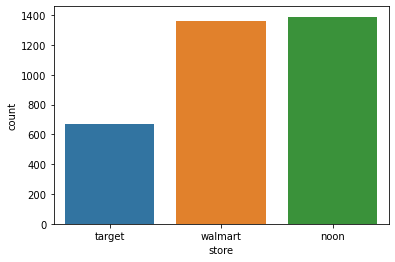

In [54]:
sns.countplot(data=store, x='store')
store['store'].value_counts()

Check the number of product category

In [55]:
store['product'].nunique()

33

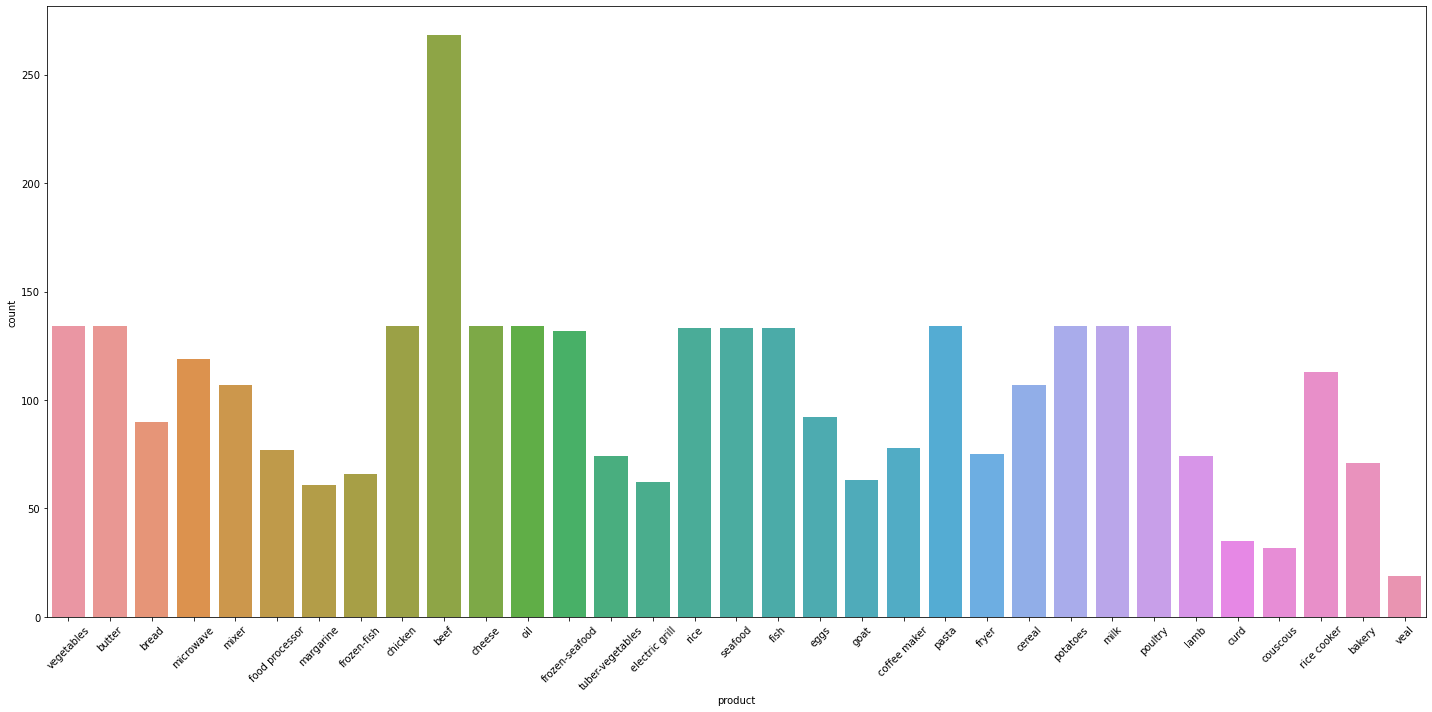

In [56]:
# Plot the number of items in each product category
plt.figure(figsize = (20,10))
sns.countplot(data=store, x='product')
plt.xticks(rotation=45)
plt.tight_layout()

The highest number items in product category is **beef** while **veal** is the lowest.

In [57]:
store['product'].value_counts()

beef                268
vegetables          134
poultry             134
milk                134
potatoes            134
pasta               134
butter              134
chicken             134
cheese              134
oil                 134
rice                133
fish                133
seafood             133
frozen-seafood      132
microwave           119
rice cooker         113
cereal              107
mixer               107
eggs                 92
bread                90
coffee maker         78
food processor       77
fryer                75
lamb                 74
tuber-vegetables     74
bakery               71
frozen-fish          66
goat                 63
electric grill       62
margarine            61
curd                 35
couscous             32
veal                 19
Name: product, dtype: int64

## Text Pre-processing

In [58]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
ps = PorterStemmer()
puncts = ['-', '"', "'", '(', ')', ',', '#', '@', ':', ';', '*', '®', '™', '.', '+', '!']

def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

def getFeatures1(description):
  features = {}
  words = [w.lower() for w in description.split() if w.lower() not in stopwords.words('english')]
  for word in words:
    feature = ps.stem(''.join([char for char in word if char not in puncts]))
    if len(feature) > 2 and not has_numbers(feature):
      features[feature] = True
  return features

def getData(row):
  return [getFeatures1(row['description']), row['product']]

allData = list(store.apply(getData, axis=1))

# Methodolody

## Running Naive Bayes Classification

In [59]:
import random

random.shuffle(allData)
testRatio = 5
splitpoint = len(allData) // testRatio
test, train = allData[:splitpoint],allData[splitpoint:]

nb = nltk.NaiveBayesClassifier.train(train)
print("NB accuracy: ", nltk.classify.accuracy(nb, test))

NB accuracy:  0.7383040935672515


## Testing Variances of Naive Bayes Model

Shuffle the data and run the machine learning model multiple times to check if the accuracy rate changes.

In [75]:
k = 10
accs = []
for _ in range(k):
  random.shuffle(allData)
  testRatio = 5
  splitpoint = len(allData) // testRatio

  test, train = allData[:splitpoint],allData[splitpoint:]
  nb = nltk.NaiveBayesClassifier.train(train)
  acc = nltk.classify.accuracy(nb, test)
  print("Iteration",_+1, "accuracy:", acc)
  accs.append(acc)

avg_acc = sum(accs)/k
print("\nAverage Accuracy:", avg_acc)

Iteration 1 accuracy: 0.7616959064327485
Iteration 2 accuracy: 0.7309941520467836
Iteration 3 accuracy: 0.7090643274853801
Iteration 4 accuracy: 0.7616959064327485
Iteration 5 accuracy: 0.7076023391812866
Iteration 6 accuracy: 0.7251461988304093
Iteration 7 accuracy: 0.7456140350877193
Iteration 8 accuracy: 0.7368421052631579
Iteration 9 accuracy: 0.7426900584795322
Iteration 10 accuracy: 0.7280701754385965

Average Accuracy: 0.7349415204678362


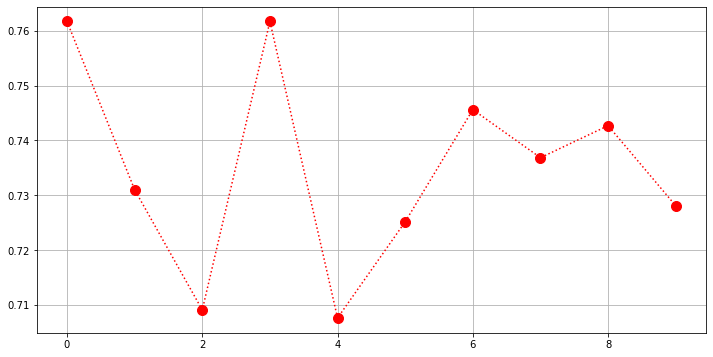

In [78]:
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(accs, 'o:r', ms=10)

## Conclusion

Running a supervised machine learning model "Naives Bayes Classification" produces an average accuracy rate of **73 percent**. This number indicates that for every 100 products in these 33 categories, we are able to obtain about 73 product categorys correctly classified. 